In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_path = "/content/drive/My Drive/test_set.zip"
import zipfile
import os

# Define the extract path
extract_folder = "/content/images"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extraction complete!")

Extraction complete!


In [3]:
# Function to count images in a list of folders
def count_images(folders):
    counts = {}
    for folder in folders:
        if os.path.exists(folder):
            num_images = len([f for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
            counts[folder] = num_images
        else:
            counts[folder] = "Folder not found"
    return counts

# Method 3: Spectral Artifact Detection

In [28]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score

# Function to apply cross-difference kernel and compute the FFT of the image
def apply_cross_kernel_and_fft(image):
    # Define the cross-difference kernel
    cross_kernel = np.array([[1, -1],
                             [-1, 1]], dtype=np.float32)

    # Apply the filter using convolution
    cross_diff = cv2.filter2D(image, -1, cross_kernel)

    # Take absolute values to match the formula
    cross_diff = np.abs(cross_diff)

    # Compute FFT of the result
    fft_result = np.fft.fft2(cross_diff)  # Compute 2D FFT
    fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency to center

    # Normalize the FFT result using its standard deviation and median
    fft_mean = np.mean(np.abs(fft_shifted))
    fft_std = np.std(np.abs(fft_shifted))
    fft_normalized = (np.abs(fft_shifted) - fft_mean) / fft_std  # Normalize FFT

    return fft_normalized

# Function to extract values from FFT image at specific points
def extract_values_from_fft(fft_image, period=4, image_size=512, kernel_size=3):
    # List to hold the extracted values
    extracted_values = []

    # Calculate the sampling points based on k * (image_size / period)
    for kx in range(period+1):
        for ky in range(period+1):
            if kx != period/2 or ky != period/2:
                # Compute the coordinates for both directions (x, y)

                x_coord = int(kx * (image_size / period))
                y_coord = int(ky * (image_size / period))

                # Make sure coordinates stay within image bounds
                # Make sure coordinates stay within image bounds
                if x_coord <= image_size and y_coord <= image_size:
                    # Define the 3x3 kernel region around (x_coord, y_coord)
                    x_min = max(x_coord - kernel_size // 2, 0)
                    x_max = min(x_coord + kernel_size // 2 + 1, image_size)
                    y_min = max(y_coord - kernel_size // 2, 0)
                    y_max = min(y_coord + kernel_size // 2 + 1, image_size)

                    # Extract the maximum value in the 3x3 kernel region
                    kernel_region = fft_image[y_min:y_max, x_min:x_max]
                    max_value = np.max(kernel_region)
                    extracted_values.append(max_value)

    return extracted_values

def process_image(image_path, period=2, image_size=512, kernel_size=3):
    # Load the image
    image = cv2.imread(image_path)

    # Check if the image is loaded correctly
    if image is None:
        raise ValueError("Image not found. Please provide a valid image path.")

    # Resize the image to the specified size (e.g., 512x512)
    image_resized = cv2.resize(image, (image_size, image_size))

    # Split the image into its Red, Green, and Blue channels
    (B, G, R) = cv2.split(image_resized)

    # Process each channel separately
    extracted_values_red = extract_values_from_fft(apply_cross_kernel_and_fft(R), period, image_size, kernel_size=kernel_size)
    extracted_values_green = extract_values_from_fft(apply_cross_kernel_and_fft(G), period, image_size, kernel_size=kernel_size)
    extracted_values_blue = extract_values_from_fft(apply_cross_kernel_and_fft(B), period, image_size, kernel_size=kernel_size)


    return extracted_values_red, extracted_values_green, extracted_values_blue


# Function to extract features from images in multiple folders
def extract_features_from_folders(folder_paths, period=2, image_size=512, kernel_size=3, num_samples=None):
    features = []
    labels = []
    all_image_paths = []

    # Collect all image paths from multiple folders
    for folder_path in folder_paths:
        image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        all_image_paths.extend(image_paths)

    # Randomly sample an equal number of images if num_samples is set
    if num_samples is not None:
        all_image_paths = random.sample(all_image_paths, min(num_samples, len(all_image_paths)))

    # Extract features from sampled images
    for image_path in all_image_paths:
        extracted_values_red, extracted_values_green, extracted_values_blue = process_image(image_path, period, image_size)

        # Combine extracted values from the three channels into a single feature vector
        feature_vector = extracted_values_red + extracted_values_green + extracted_values_blue
        features.append(feature_vector)

        # Assign label (1 for real, 0 for fake) based on folder category
        label = 1 if "real" in image_path.lower() else 0
        labels.append(label)

    return np.array(features), np.array(labels)

# Function to plot the feature importances of the trained Random Forest model
def plot_feature_importances(clf, feature_names):
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Feature Importances of Random Forest Classifier")
    plt.tight_layout()
    plt.show()

# Train and evaluate the classifier with multiple real and fake folders
def train_and_evaluate_classifier(real_folders, fake_folders, period=2, image_size=512, kernel_size=3, random_state=42):
    # Count the number of images in each category across all folders
    num_real = sum(len([f for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]) for folder in real_folders)
    num_fake = sum(len([f for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]) for folder in fake_folders)

    # Use the minimum count to balance dataset
    min_samples = min(num_real, num_fake)

    # Extract features from multiple real and fake folders
    real_features, real_labels = extract_features_from_folders(real_folders, period, image_size, kernel_size)
    fake_features, fake_labels = extract_features_from_folders(fake_folders, period, image_size, kernel_size)

    real_features_mean = np.mean(real_features, axis=0)
    print(f"Mean over all real features: {np.mean(real_features_mean)}")

    fake_features_mean = np.mean(fake_features, axis=0)
    print(f"Mean over all fake features: {np.mean(fake_features_mean)}")

    # Combine the real and fake features and labels
    features = np.concatenate((real_features, fake_features), axis=0)
    labels = np.concatenate((real_labels, fake_labels), axis=0)

    # Split the dataset into training and testing sets while keeping the classes balanced
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=random_state)

    # Train the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Generate feature names based on extracted values per color channel
    num_features_per_channel = features.shape[1] // 3
    print(num_features_per_channel)
    feature_names = [f"{color}_Feature_{i+1}" for color in ['Red', 'Green', 'Blue'] for i in range(num_features_per_channel)]

    # Plot feature importances
    plot_feature_importances(clf, np.array(feature_names))
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Change 'weighted' based on your needs
    recall = recall_score(y_test, y_pred, average='weighted')  # Change 'weighted' based on your needs

    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Model F1 Score: {f1:.4f}")
    print(f"Model Recall: {recall:.4f}")

    return clf



# In-Domain Experiments

1- FFHQ Fake vs. Real

In [29]:
import os

# Define the folders
real_folders = [
    #"/content/images/test_set/real_coco_valid",
    "/content/images/test_set/real_ffhq",
    #"/content/images/test_set/real_imagenet_val"
]

fake_folders = [
    "/content/images/test_set/latent-diffusion_noise2image_FFHQ",
    "/content/images/test_set/stylegan2_ffhq_1024x1024",
    "/content/images/test_set/stylegan2_ffhq_256x256"
]


# Count images
real_counts = count_images(real_folders)
fake_counts = count_images(fake_folders)

# Print results
print("Real Image Counts:")
for folder, count in real_counts.items():
    print(f"{folder}: {count}")

print("\nFake Image Counts:")
for folder, count in fake_counts.items():
    print(f"{folder}: {count}")


Real Image Counts:
/content/images/test_set/real_ffhq: 1000

Fake Image Counts:
/content/images/test_set/latent-diffusion_noise2image_FFHQ: 100
/content/images/test_set/stylegan2_ffhq_1024x1024: 333
/content/images/test_set/stylegan2_ffhq_256x256: 167


Spectral Artifact Detection on 1- FFHQ Fake vs. Real

Mean over all real features: 0.6629787926244652
Mean over all fake features: 1.4954868977342113
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.76      0.82       120
           1       0.87      0.95      0.91       200

    accuracy                           0.88       320
   macro avg       0.88      0.85      0.87       320
weighted avg       0.88      0.88      0.88       320

80


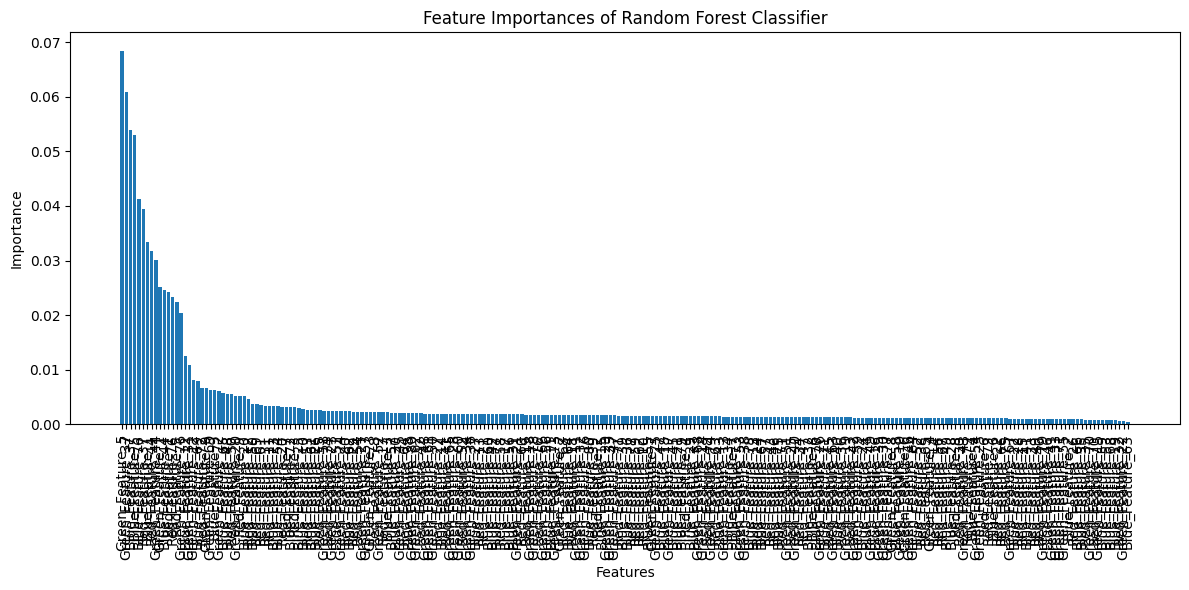

Model Accuracy: 0.8781
Model F1 Score: 0.8756
Model Recall: 0.8781


In [30]:
clf = train_and_evaluate_classifier(real_folders, fake_folders, period=8, image_size=512, kernel_size=3, random_state=42)

2. COCO Fake vs. Real

In [31]:
import os

# Define the folders
real_folders = [
    "/content/images/test_set/real_coco_valid",
#    "/content/images/test_set/real_ffhq",
#    "/content/images/test_set/real_imagenet_val"
]

fake_folders = [
    "/content/images/test_set/dalle3_cocoval",
#    "/content/images/test_set/dalle_2",
#    "/content/images/test_set/stable_diffusion_2_1_512",
#    "/content/images/test_set/stable_diffusion_2_1_768",
#    "/content/images/test_set/biggan_512",
#    "/content/images/test_set/biggan_256",
    "/content/images/test_set/GigaGAN_t2i_coco256_rep",
#    "/content/images/test_set/latent-diffusion_noise2image_FFHQ",
#    "/content/images/test_set/stylegan2_ffhq_1024x1024",
#    "/content/images/test_set/stylegan2_ffhq_256x256"
]


# Count images
real_counts = count_images(real_folders)
fake_counts = count_images(fake_folders)

# Print results
print("Real Image Counts:")
for folder, count in real_counts.items():
    print(f"{folder}: {count}")

print("\nFake Image Counts:")
for folder, count in fake_counts.items():
    print(f"{folder}: {count}")

Real Image Counts:
/content/images/test_set/real_coco_valid: 1000

Fake Image Counts:
/content/images/test_set/dalle3_cocoval: 1000
/content/images/test_set/GigaGAN_t2i_coco256_rep: 250


SIFT on 2. COCO Fake vs. Real

Mean over all real features: 0.9554495614762779
Mean over all fake features: 1.3299400466786153
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       250
           1       0.99      0.98      0.99       200

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450

80


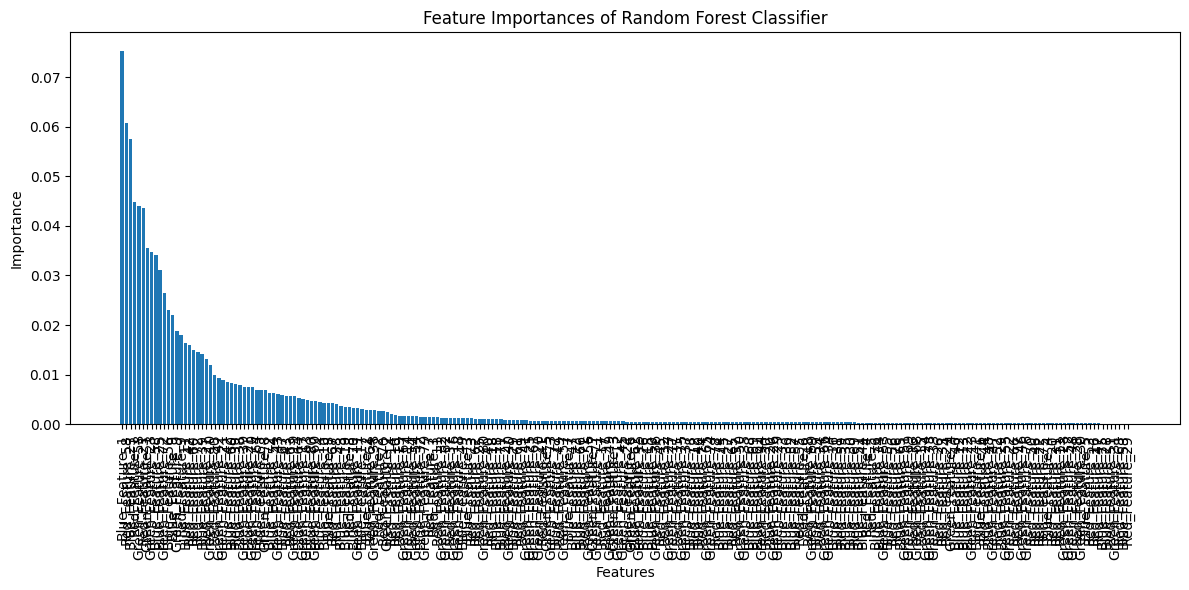

Model Accuracy: 0.9889
Model F1 Score: 0.9889
Model Recall: 0.9889


In [32]:
clf = train_and_evaluate_classifier(real_folders, fake_folders, period=8, image_size=512, kernel_size=3, random_state=42)

# In-Method Experiments

1. Real vs. DALLE2/3 (Mainly COCO kind)

In [33]:
import os

# Define the folders
real_folders = [
    "/content/images/test_set/real_coco_valid",
#    "/content/images/test_set/real_ffhq",
    "/content/images/test_set/real_imagenet_val"
]

fake_folders = [
    "/content/images/test_set/dalle3_cocoval",
    "/content/images/test_set/dalle_2",
#    "/content/images/test_set/stable_diffusion_2_1_512",
#    "/content/images/test_set/stable_diffusion_2_1_768",
#    "/content/images/test_set/biggan_512",
#    "/content/images/test_set/biggan_256",
#    "/content/images/test_set/GigaGAN_t2i_coco256_rep",
#    "/content/images/test_set/latent-diffusion_noise2image_FFHQ",
#    "/content/images/test_set/stylegan2_ffhq_1024x1024",
#    "/content/images/test_set/stylegan2_ffhq_256x256"
]


# Count images
real_counts = count_images(real_folders)
fake_counts = count_images(fake_folders)

# Print results
print("Real Image Counts:")
for folder, count in real_counts.items():
    print(f"{folder}: {count}")

print("\nFake Image Counts:")
for folder, count in fake_counts.items():
    print(f"{folder}: {count}")

Real Image Counts:
/content/images/test_set/real_coco_valid: 1000
/content/images/test_set/real_imagenet_val: 1000

Fake Image Counts:
/content/images/test_set/dalle3_cocoval: 1000
/content/images/test_set/dalle_2: 1000


Spectral Artifact Detection on 1. Real vs. DALLE2/3 (Mainly COCO kind)

Mean over all real features: 0.7976817518433325
Mean over all fake features: 0.795973625600196
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       400
           1       0.97      0.96      0.97       400

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800

80


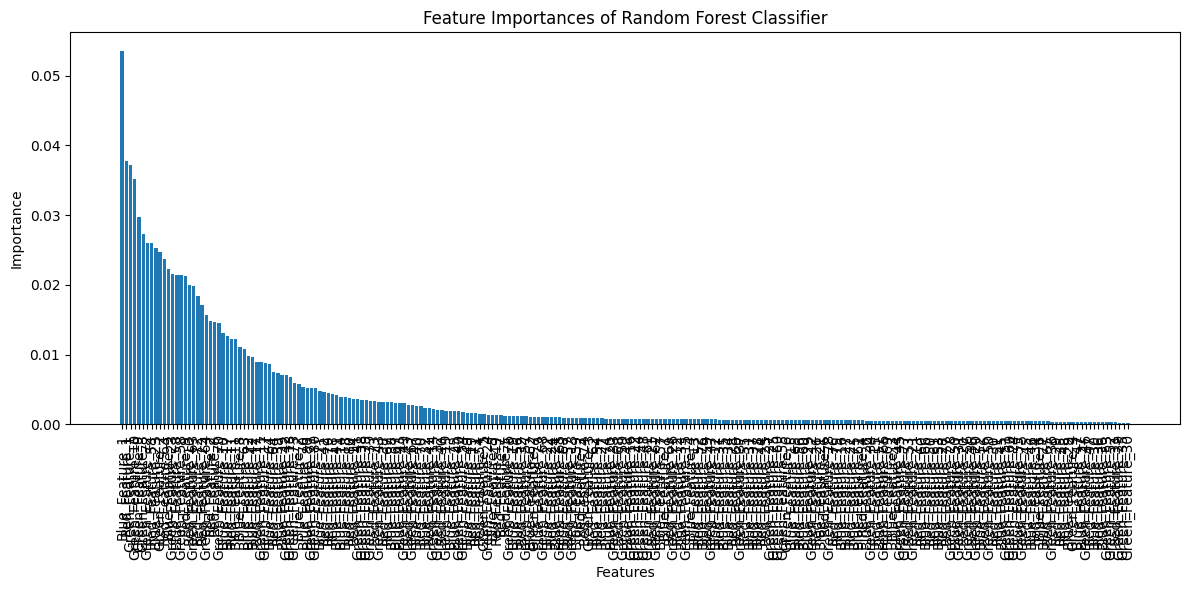

Model Accuracy: 0.9663
Model F1 Score: 0.9662
Model Recall: 0.9663


In [34]:
clf = train_and_evaluate_classifier(real_folders, fake_folders, period=8, image_size=512, kernel_size=3, random_state=42)

2. Real vs. SDXL/SD2 (Mainly COCO kind)

In [35]:
import os

# Define the folders
real_folders = [
    "/content/images/test_set/real_coco_valid",
#    "/content/images/test_set/real_ffhq",
    "/content/images/test_set/real_imagenet_val"
]

fake_folders = [
#    "/content/images/test_set/dalle3_cocoval",
#    "/content/images/test_set/dalle_2",
    "/content/images/test_set/stable_diffusion_2_1_512",
    "/content/images/test_set/stable_diffusion_2_1_768",
     "/content/images/test_set/sdxl_cocoval"
#    "/content/images/test_set/biggan_512",
#    "/content/images/test_set/biggan_256",
#    "/content/images/test_set/GigaGAN_t2i_coco256_rep",
#    "/content/images/test_set/latent-diffusion_noise2image_FFHQ",
#    "/content/images/test_set/stylegan2_ffhq_1024x1024",
#    "/content/images/test_set/stylegan2_ffhq_256x256"
]


# Count images
real_counts = count_images(real_folders)
fake_counts = count_images(fake_folders)

# Print results
print("Real Image Counts:")
for folder, count in real_counts.items():
    print(f"{folder}: {count}")

print("\nFake Image Counts:")
for folder, count in fake_counts.items():
    print(f"{folder}: {count}")

Real Image Counts:
/content/images/test_set/real_coco_valid: 1000
/content/images/test_set/real_imagenet_val: 1000

Fake Image Counts:
/content/images/test_set/stable_diffusion_2_1_512: 400
/content/images/test_set/stable_diffusion_2_1_768: 300
/content/images/test_set/sdxl_cocoval: 1000


Spectral Artifact Detection on 2. Real vs. SDXL/SD2 (Mainly COCO kind)

Mean over all real features: 0.7976817518433325
Mean over all fake features: 1.0842038590744068
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       340
           1       0.98      0.98      0.98       400

    accuracy                           0.98       740
   macro avg       0.98      0.98      0.98       740
weighted avg       0.98      0.98      0.98       740

80


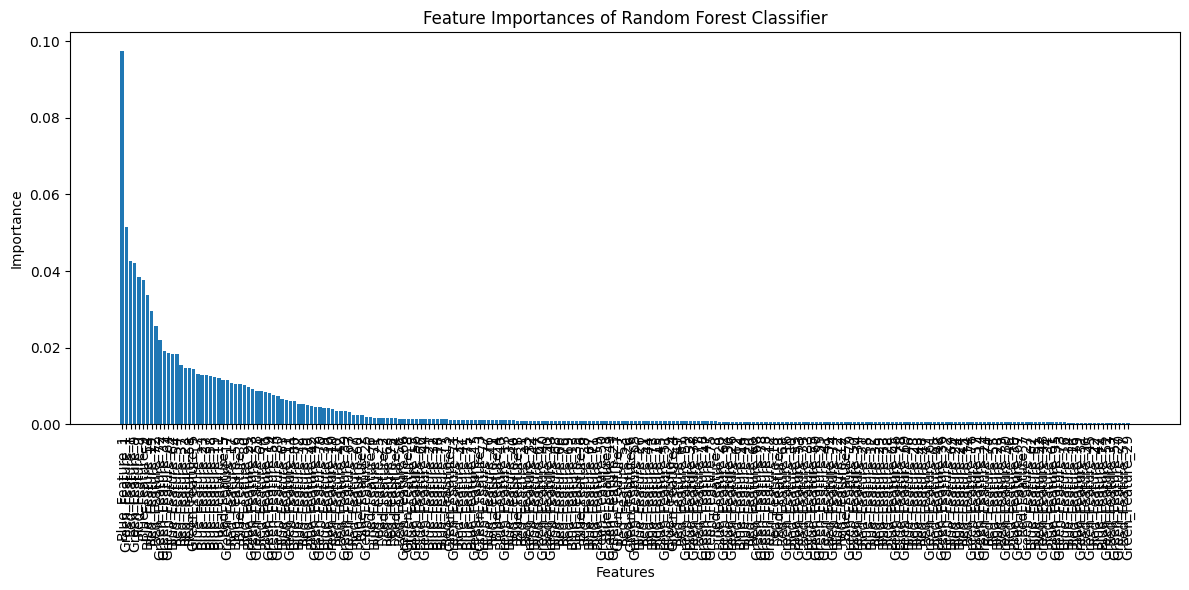

Model Accuracy: 0.9757
Model F1 Score: 0.9757
Model Recall: 0.9757


In [36]:
clf = train_and_evaluate_classifier(real_folders, fake_folders, period=8, image_size=512, kernel_size=3, random_state=42)

# Real vs. Fake Comprehensive Experiments

Real Coco + Imagenet vs. Dalle 3 + Stable Diffusion + BigGAN

In [37]:
import os

# Define the folders
real_folders = [
    "/content/images/test_set/real_coco_valid",
#    "/content/images/test_set/real_ffhq",
    "/content/images/test_set/real_imagenet_val"
]

fake_folders = [
    "/content/images/test_set/dalle3_cocoval",
#    "/content/images/test_set/dalle_2",
    "/content/images/test_set/stable_diffusion_2_1_512",
#    "/content/images/test_set/stable_diffusion_2_1_768",
#     "/content/images/test_set/sdxl_cocoval",
     "/content/images/test_set/biggan_512",
#    "/content/images/test_set/biggan_256",
#    "/content/images/test_set/GigaGAN_t2i_coco256_rep",
#    "/content/images/test_set/latent-diffusion_noise2image_FFHQ",
#    "/content/images/test_set/stylegan2_ffhq_1024x1024",
#    "/content/images/test_set/stylegan2_ffhq_256x256"
]


# Count images
real_counts = count_images(real_folders)
fake_counts = count_images(fake_folders)

# Print results
print("Real Image Counts:")
for folder, count in real_counts.items():
    print(f"{folder}: {count}")

print("\nFake Image Counts:")
for folder, count in fake_counts.items():
    print(f"{folder}: {count}")

Real Image Counts:
/content/images/test_set/real_coco_valid: 1000
/content/images/test_set/real_imagenet_val: 1000

Fake Image Counts:
/content/images/test_set/dalle3_cocoval: 1000
/content/images/test_set/stable_diffusion_2_1_512: 400
/content/images/test_set/biggan_512: 500


Spectral Artifact Detection on Real Coco + Imagenet vs. Dalle 3 + Stable Diffusion + BigGAN

Mean over all real features: 0.7976817518433325
Mean over all fake features: 1.0756174569125696
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       380
           1       0.96      0.96      0.96       400

    accuracy                           0.96       780
   macro avg       0.96      0.96      0.96       780
weighted avg       0.96      0.96      0.96       780

80


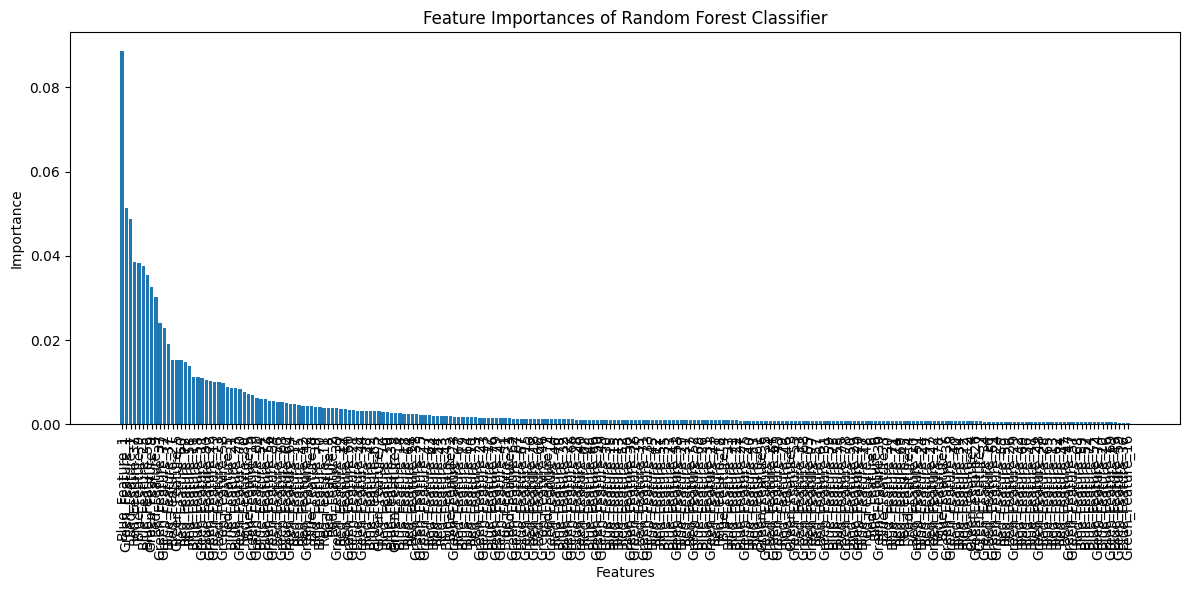

Model Accuracy: 0.9615
Model F1 Score: 0.9615
Model Recall: 0.9615


In [38]:
clf = train_and_evaluate_classifier(real_folders, fake_folders, period=8, image_size=512, kernel_size=3, random_state=42)

# Creating the FFT Visualizations

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os



# Function to compute the FFT of an image after applying cross-difference filter for a single channel
def compute_fft(image):
    # Define the cross-difference kernel
    cross_kernel = np.array([[1, -1],
                             [-1, 1]], dtype=np.float32)

    # Apply the filter using convolution
    cross_diff = cv2.filter2D(image, -1, cross_kernel)

    # Take absolute values to match the formula
    cross_diff = np.abs(cross_diff)

    # Normalize for better visualization
    cross_diff = (cross_diff / cross_diff.max() * 255).astype(np.uint8)

    # Compute FFT of the result
    fft_result = np.fft.fft2(cross_diff)  # Compute 2D FFT
    fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency to center
    magnitude_spectrum = np.log(1 + np.abs(fft_shifted))  # Compute magnitude spectrum

    return magnitude_spectrum

# Function to process all images in a folder and compute average FFTs for each color channel
def process_images_in_folder(folder_path, resize=None):
    fft_red_sum = None
    fft_green_sum = None
    fft_blue_sum = None
    image_count = 0

    # List all image files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):  # Add more extensions if needed
            image_path = os.path.join(folder_path, filename)

            # Load the image in color
            image = cv2.imread(image_path)
            if resize:
                image = cv2.resize(image, resize)

            if image is None:
                print(f"Warning: Could not load image {filename}. Skipping...")
                continue

            # Split the image into the red, green, and blue channels
            (blue, green, red) = cv2.split(image)

            # Compute FFT for each channel
            fft_red = compute_fft(red)
            fft_green = compute_fft(green)
            fft_blue = compute_fft(blue)

            # Sum the FFTs for each channel
            if fft_red_sum is None:
                fft_red_sum = fft_red
            else:
                fft_red_sum += fft_red

            if fft_green_sum is None:
                fft_green_sum = fft_green
            else:
                fft_green_sum += fft_green

            if fft_blue_sum is None:
                fft_blue_sum = fft_blue
            else:
                fft_blue_sum += fft_blue

            image_count += 1

    # If no images were processed, return None
    if image_count == 0:
        print("No valid images found in the folder.")
        return None

    # Average the FFT results for each channel
    avg_fft_red = fft_red_sum / image_count
    avg_fft_green = fft_green_sum / image_count
    avg_fft_blue = fft_blue_sum / image_count

    # Combine the average FFTs across the three channels (you can choose to handle them differently)
    average_fft = (avg_fft_red + avg_fft_green + avg_fft_blue) / 3

    return avg_fft_red, avg_fft_green, avg_fft_blue, average_fft


# Function to apply morphological dilation to enhance visual peaks in the FFT image
def apply_dilation(image, kernel_size=(5, 5)):
    """
    Apply morphological dilation to the FFT image to enlarge the peaks for better visualization.
    kernel_size: The size of the kernel to be used for dilation.
    """
    kernel = np.ones(kernel_size, np.uint8)  # Create a square kernel for dilation
    dilated_image = cv2.dilate(image, kernel, iterations=1)  # Apply dilation
    return dilated_image


def plot_fft_average_image(folder_path, title, kernel_size=(5,5)):
    # Process images in the folder and get the average FFT for each color channel
    avg_fft_red, avg_fft_green, avg_fft_blue, average_fft = process_images_in_folder(folder_path, resize=(512, 512))

    # If FFTs were computed, apply contrast enhancement and find local peaks
    if average_fft is not None:
        # Apply morphological dilation to the average FFT image
        dilated_fft = apply_dilation(average_fft, kernel_size=kernel_size)  # Change kernel size if needed

        # Plot the results
        plt.figure(figsize=(15, 15))

        # Combined Enhanced FFT (after dilation)
        plt.imshow(dilated_fft, cmap="hot")
        plt.title(title)
        plt.axis("off")
        plt.savefig(title+".png")

        plt.show()


folder_paths = {
    "DALL-E 3":"/content/images/test_set/dalle3_cocoval",
    "DALL-E 2":"/content/images/test_set/dalle_2",
    "Stable Diffusion 2.1":"/content/images/test_set/stable_diffusion_2_1_512",
    "SDXL":"/content/images/test_set/sdxl_cocoval",
    "GAN":"/content/images/test_set/biggan_512",
    "Real (COCO)": "/content/images/test_set/real_coco_valid",
    "Real (FFHQ)": "/content/images/test_set/real_ffhq",
    "Real (ImageNet)": "/content/images/test_set/real_imagenet_val",
}



for title, folder_path in folder_paths.items():
    plot_fft_average_image(folder_path, title)